**Analisi di vulnerabilità**

Analisi delle caratteristiche e della vulnerabilità della Rete di Trasporto Pubblica Metropolitana Milanese  
*Progetto del corso di Data Analytics*


Andrea Broccoletti  
*Matricola 886155*

In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
graph_file = "../assets/static/graphs/atm_network.pkl"

In [3]:
G = ig.Graph.Read_Pickle(graph_file)

# Definizioni principali

## Indici dei nodi

In [4]:
N = G.vcount()
orig_indices = list(range(N))
G.vs['orig_idx'] = orig_indices

## Iterazioni

In [5]:
fractions = np.linspace(0, 0.5, 26) # Frazione di nodi rimossi da 0 a 0.5
reps_random = 12 # Numero di ripetizioni per attacco casuale

# Gradi e betweenness

In [6]:
deg = np.array(G.degree()) # Grado dei nodi
order_degree = list(np.argsort(deg)[::-1]) # Ordine dei nodi per grado decrescente

In [7]:
btw = np.array(G.betweenness()) # Betweenness dei nodi
order_btw = list(np.argsort(btw)[::-1]) # Ordine dei nodi per betweenness decrescente

# Funzione di calcolo delle metriche
Necessaria per l'esecuzione degli attacchi, ad ogni iterazione di attacco vengono  
ricalcolate per studiare l'effetto dell'attacco.

In [8]:
def graph_metrics(G):

    out = {}
    n = G.vcount()
    out['n_nodes'] = n
    out['n_edges'] = G.ecount()

    comps = G.components()
    sizes = comps.sizes()

    out['n_components'] = len(sizes)
    out['gcc_size'] = max(sizes) if sizes else 0
    out['gcc_frac'] = out['gcc_size'] / n if n>0 else 0

    try:
        gcc = comps.giant()
        if gcc.vcount() > 1:
            out['avg_path_len'] = gcc.average_path_length(directed=False)
        else:
            out['avg_path_len'] = np.nan
    except Exception:
        out['avg_path_len'] = np.nan

    try:
        out['transitivity'] = G.transitivity_undirected()
    except Exception:
        out['transitivity'] = np.nan

    return out

# Funzioni di attacco

## Attacco mirato

In [9]:
def run_attack(G_orig, order, fractions):

    results = [] # lista di dizionari con i risultati

    N = G_orig.vcount() # numero di nodi originali
    Gc = G_orig.copy() # copia del grafo su cui operare
    Gc.vs['orig_idx'] = list(range(Gc.vcount()))

    removed_set = set() # set di nodi rimossi finora
    pointer = 0 # puntatore nell'ordine di rimozione

    for frac in fractions:
        target = int(frac * N) # numero di nodi da rimuovere a questo step

        # rimozione di nodi fino a raggiungimento del target
        while len(removed_set) < target and pointer < len(order):

            orig_to_remove = order[pointer]
            pointer += 1

            try:
                v = Gc.vs.find(orig_idx=orig_to_remove)
                Gc.delete_vertices(v.index)
                removed_set.add(orig_to_remove)
            except Exception:
                continue # Nodo già rimosso

        results.append({'frac_removed': len(removed_set)/N, **graph_metrics(Gc)})
        
    return results

## Attacco a cascata

In [10]:
def run_attack_cascade(G_orig, method, fractions):

    results = []
    N = G_orig.vcount()

    for frac in fractions:

        target = int(frac * N)
        Gc = G_orig.copy()
        removed = 0

        while removed < target and Gc.vcount() > 0:

            if method == 'degree':
                scores = np.array(Gc.degree())
            elif method == 'betweenness':
                scores = np.array(Gc.betweenness())

            if scores.size == 0:
                break

            idx = int(np.argmax(scores))

            Gc.delete_vertices(idx)
            removed += 1

        results.append({'frac_removed': removed / N, **graph_metrics(Gc)})
        
    return results

# Esecuzione degli attacchi

## Attacco casuale (n volte)

In [11]:
all_random = []

for rep in range(reps_random):
    order = list(np.random.permutation(N))
    res = run_attack(G, order, fractions)
    all_random.append(res)

def aggregate_runs(runs):

    ag = []
    for i in range(len(fractions)):
        agg = {'frac_removed': fractions[i]}

        for k in ['gcc_frac','n_components','avg_path_len','transitivity','n_lines','n_nodes','n_edges','frac_removed']:
            vals = [r[i].get(k, np.nan) for r in runs]
            agg[k+'_mean'] = np.nanmean(vals)
            agg[k+'_std'] = np.nanstd(vals)
        ag.append(agg)

    return ag

random_agg = aggregate_runs(all_random)

/var/folders/7y/3hmq48t14mb2btvcr85krp780000gn/T/ipykernel_82830/2025805157.py:16: RuntimeWarning: Mean of empty slice
  agg[k+'_mean'] = np.nanmean(vals)
/Users/brock/Developer/analisi da csv/env/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Attacchi mirati e a cascata

In [12]:
# Attacco basato sul grado
res_deg = run_attack(G, order_degree, fractions)

# Attacco basato sulla betweenness
res_btw = run_attack(G, order_btw, fractions)

# Attacco basato sul grado (cascade)
res_deg_cascade = run_attack_cascade(G, "degree", fractions)

# Attacco basato sulla betweenness (cascade)
res_btw_cascade = run_attack_cascade(G, "betweenness", fractions)

In [13]:
df_deg = pd.DataFrame(res_deg)
df_btw = pd.DataFrame(res_btw)
df_deg_c = pd.DataFrame(res_deg_cascade)
df_btw_c = pd.DataFrame(res_btw_cascade)
df_rand_agg = pd.DataFrame(random_agg)

# Grafici dei risultati

## Grafici comparativi

In [14]:
plt.rcParams['figure.figsize'] = (9,6)

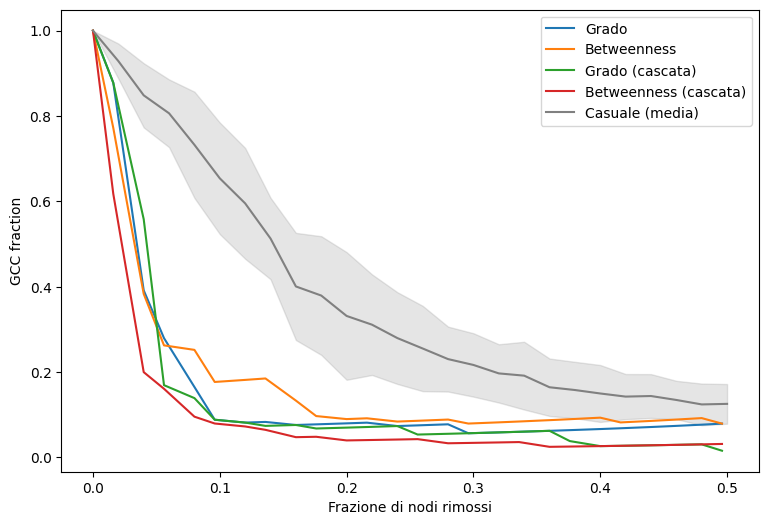

In [15]:
fig, ax = plt.subplots()

ax.plot(df_deg['frac_removed'], df_deg['gcc_frac'], label='Grado')
ax.plot(df_btw['frac_removed'], df_btw['gcc_frac'], label='Betweenness')
ax.plot(df_deg_c['frac_removed'], df_deg_c['gcc_frac'], label='Grado (cascata)')
ax.plot(df_btw_c['frac_removed'], df_btw_c['gcc_frac'], label='Betweenness (cascata)')

ax.plot(df_rand_agg['frac_removed'], df_rand_agg['gcc_frac_mean'], label='Casuale (media)', color='gray')
ax.fill_between(df_rand_agg['frac_removed'], df_rand_agg['gcc_frac_mean']-df_rand_agg['gcc_frac_std'], df_rand_agg['gcc_frac_mean']+df_rand_agg['gcc_frac_std'], color='gray', alpha=0.2)
ax.set_xlabel('Frazione di nodi rimossi')
ax.set_ylabel('GCC fraction')

ax.legend()
plt.show()

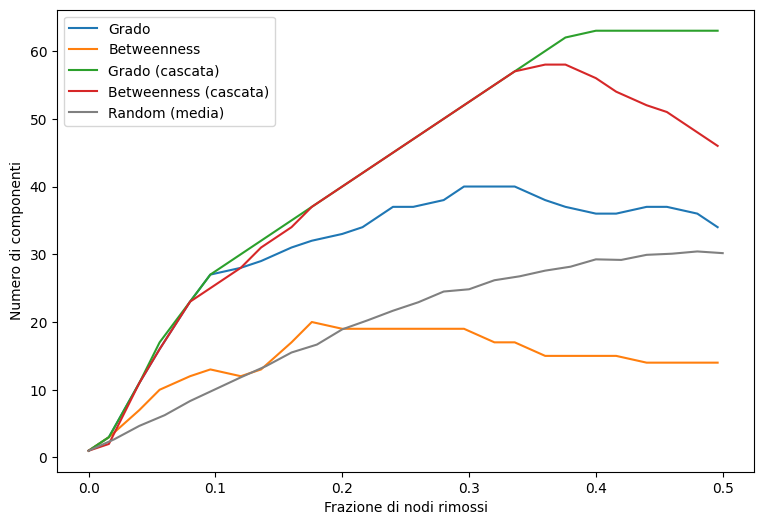

In [16]:
fig, ax = plt.subplots()

ax.plot(df_deg['frac_removed'], df_deg['n_components'], label='Grado')
ax.plot(df_btw['frac_removed'], df_btw['n_components'], label='Betweenness')
ax.plot(df_deg_c['frac_removed'], df_deg_c['n_components'], label='Grado (cascata)')
ax.plot(df_btw_c['frac_removed'], df_btw_c['n_components'], label='Betweenness (cascata)')
ax.plot(df_rand_agg['frac_removed'], df_rand_agg['n_components_mean'], label='Random (media)', color='gray')
ax.set_xlabel('Frazione di nodi rimossi')
ax.set_ylabel('Numero di componenti')

ax.legend()
plt.show()

## Grafici singoli

In [17]:
plt.rcParams['figure.figsize'] = (10,4)

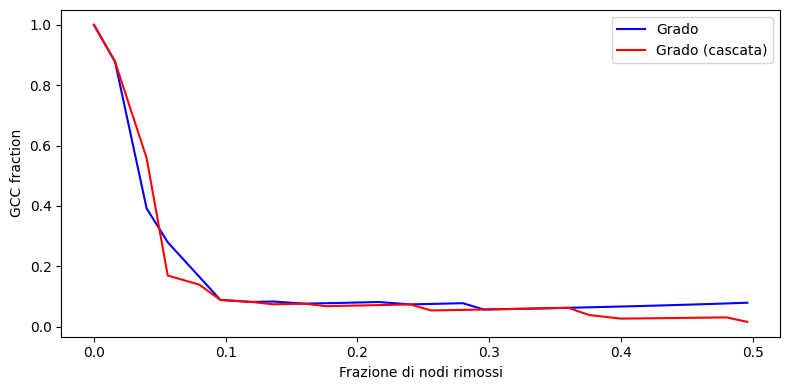

In [18]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df_deg['frac_removed'], df_deg['gcc_frac'], label='Grado', color='blue')
ax.plot(df_deg_c['frac_removed'], df_deg_c['gcc_frac'], label='Grado (cascata)', color='red')
ax.set_xlabel('Frazione di nodi rimossi')
ax.set_ylabel('GCC fraction')

ax.legend()
plt.tight_layout()
plt.show()

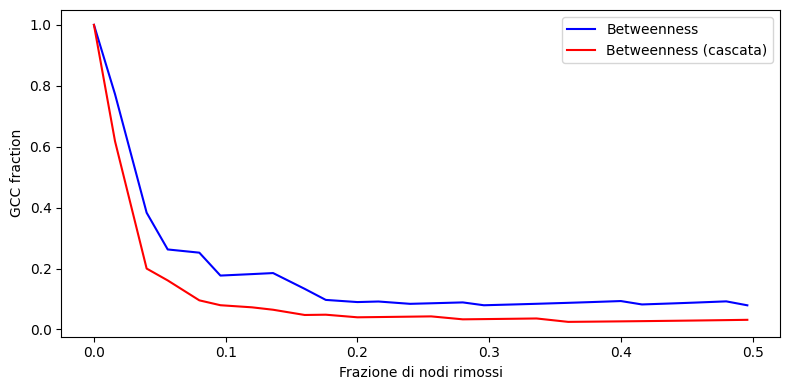

In [19]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df_btw['frac_removed'], df_btw['gcc_frac'], label='Betweenness', color='blue')
ax.plot(df_btw_c['frac_removed'], df_btw_c['gcc_frac'], label='Betweenness (cascata)', color='red')
ax.set_xlabel('Frazione di nodi rimossi')
ax.set_ylabel('GCC fraction')

ax.legend()
plt.tight_layout()
plt.show()

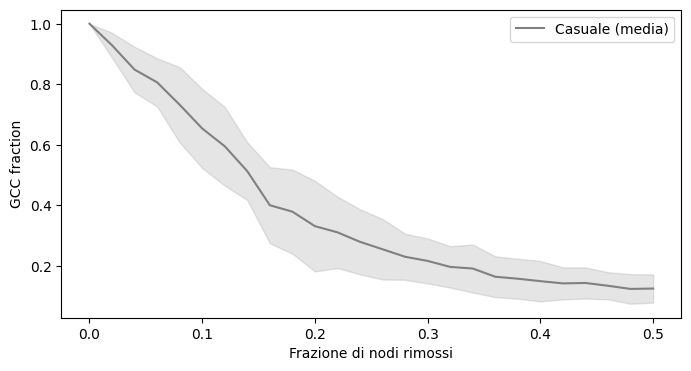

In [20]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df_rand_agg['frac_removed'], df_rand_agg['gcc_frac_mean'], label='Casuale (media)', color='gray')
ax.fill_between(df_rand_agg['frac_removed'], df_rand_agg['gcc_frac_mean']-df_rand_agg['gcc_frac_std'], df_rand_agg['gcc_frac_mean']+df_rand_agg['gcc_frac_std'], color='gray', alpha=0.2)
ax.set_xlabel('Frazione di nodi rimossi')
ax.set_ylabel('GCC fraction')

ax.legend()
plt.show()